# Actividad grupal: Detección de anomalías y técnicas de agrupamiento
# Castro Luis, Ponce Miguel, Raul Sanchez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Nota
<p align="justify">
Para el presente trabajo no se realizará la separación de datos en conjunto de prueba y test, considerando que en la detección de anomalías generalmente se buscan los valores atípicos. Debido a que las técnicas de agrupamiento son no supervisadas, se va a formar y revisar si los clústeres resultantes coinciden con estas etiquetas Esto en función de las consultas realizadas en clase y en el foro.
</p>

## Introducción 
<p align="justify">
Las técnicas de clustering son algoritmos no supervisados, dado que proporcionan una estructura de datos a un conjunto de datos sin etiquetar, es decir realizan agrupaciones de manera coherente dentro de un conjunto de datos sin etiquetar en subconjuntos o clusters.
Esta agrupación de datos se la realiza mediante el concepto de proximidad entres ellos. 

</p>

## Funciones auxiliares

In [2]:
# Original code: https://bit.ly/2TNHBZ5
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

# Análisis descriptivo de los datos:

In [3]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## Evaluación de datos faltantes

In [4]:
df = pd.read_csv("creditcardcsvpresent.csv")

In [5]:
df

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,Y,0,N,N,754,585.0,7,N
3071,6661273532,NaN,800.0,0.0,Y,0,N,N,754,585.0,7,N
3072,6661273533,NaN,800.0,20800.0,Y,0,N,N,754,585.0,7,N
3073,6661273532,NaN,1500.0,12000.0,Y,0,Y,Y,754,585.0,7,N


In [6]:
missing_data = df.isnull()

In [7]:
missing_data.head()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False


In [8]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

Merchant_id
False    3075
Name: Merchant_id, dtype: int64

Transaction date
True    3075
Name: Transaction date, dtype: int64

Average Amount/transaction/day
False    3075
Name: Average Amount/transaction/day, dtype: int64

Transaction_amount
False    3075
Name: Transaction_amount, dtype: int64

Is declined
False    3075
Name: Is declined, dtype: int64

Total Number of declines/day
False    3075
Name: Total Number of declines/day, dtype: int64

isForeignTransaction
False    3075
Name: isForeignTransaction, dtype: int64

isHighRiskCountry
False    3075
Name: isHighRiskCountry, dtype: int64

Daily_chargeback_avg_amt
False    3075
Name: Daily_chargeback_avg_amt, dtype: int64

6_month_avg_chbk_amt
False    3075
Name: 6_month_avg_chbk_amt, dtype: int64

6-month_chbk_freq
False    3075
Name: 6-month_chbk_freq, dtype: int64

isFradulent
False    3075
Name: isFradulent, dtype: int64



<p align="justify">
Nuestro dataset contiene 3075 y 12 columnas se procederá a eliminar la columna Transaction date ya que no contiene información, todos sus valores son NULOS
</p>

In [9]:
df = df.drop(['Transaction date'], axis=1)

## De las variables numéricas hallar el valor mínimo, el máximo, la mediana y la media.

In [10]:
df.describe()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq
count,3.075000e+03,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,5.026634e+09,515.026556,9876.399210,0.957398,55.737561,40.022407,0.391870
std,9.870778e+08,291.906978,10135.331016,2.192391,206.634779,155.968840,1.548479
min,3.160041e+09,4.011527,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.170814e+09,269.788047,2408.781147,0.000000,0.000000,0.000000,0.000000
50%,5.025578e+09,502.549575,6698.891856,0.000000,0.000000,0.000000,0.000000
75%,5.889625e+09,765.272803,14422.568935,0.000000,0.000000,0.000000,0.000000
max,6.665906e+09,2000.000000,108000.000000,20.000000,998.000000,998.000000,9.000000


## De las variables categóricas, listar las diferentes categorías y hallar la frecuencia de cada una de ellas

In [11]:
var_num = df._get_numeric_data().columns.values.tolist()

In [12]:
data_vars = df.columns.values.tolist()

In [13]:
to_keep = [v for v in data_vars if v not in var_num]

In [14]:
for v in to_keep:
    print(v)
    print(df[v].value_counts())
    print("__________________________________")

Is declined
N    3018
Y      57
Name: Is declined, dtype: int64
__________________________________
isForeignTransaction
N    2369
Y     706
Name: isForeignTransaction, dtype: int64
__________________________________
isHighRiskCountry
N    2870
Y     205
Name: isHighRiskCountry, dtype: int64
__________________________________
isFradulent
N    2627
Y     448
Name: isFradulent, dtype: int64
__________________________________


## Hallar todas las correlaciones existentes entre las variables numéricas del conjunto de datos


In [15]:
var_num = df._get_numeric_data().columns.values.tolist()

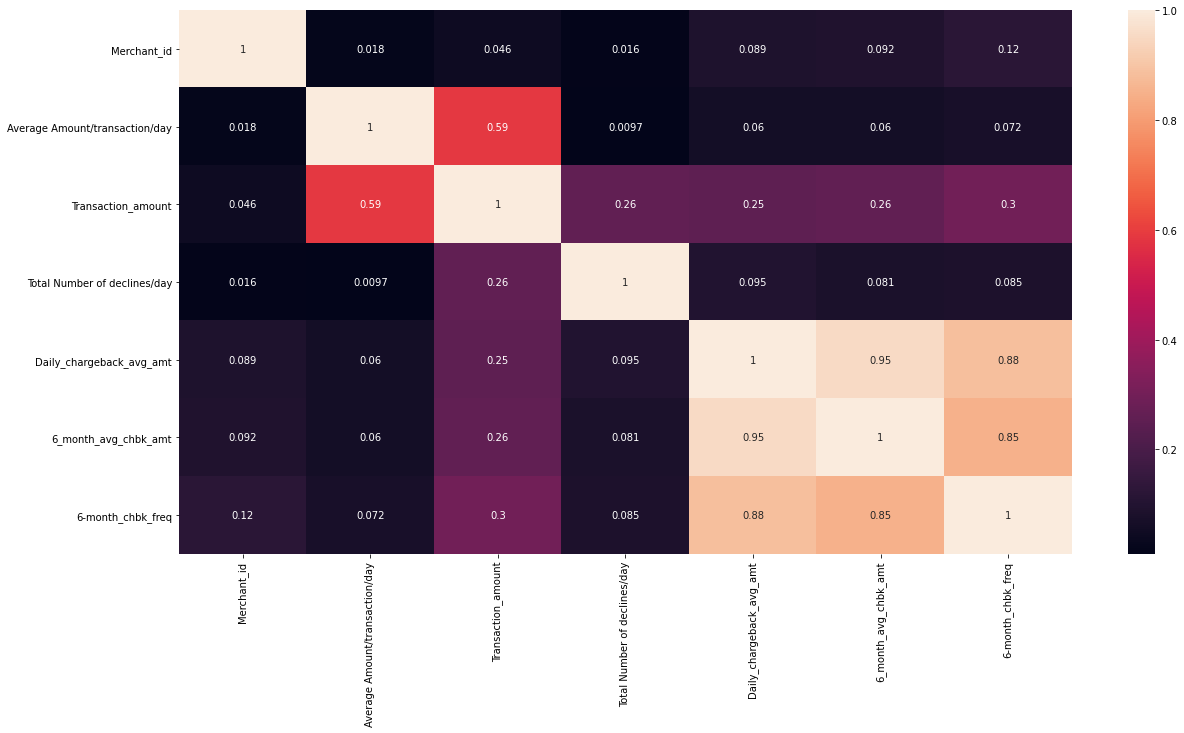

In [16]:
plt.figure(figsize = (20, 10))
sns.heatmap(df[var_num].corr().abs(), annot = True)

<p align="justify">
Como se puede observar existe una alta correlación entre las variables Daily_chargeback_avg_amt, 6_month_avg_chbk_amt y 6-month_chbk_freq; generalmente en los modelos se busca variables correladas con respecto a la variable objetivo y más decorreladas entre sí. Si luego del análisis de las métricas se observa efectos no deseados se puede presumir que la inclusión de estas variables pudo afectar el modelo.
</p>

In [17]:
df_cols = df[var_num].corr().stack().reset_index()
df_cols.columns = ['VariableA','VariableB','correlation']
df_corr = df_cols[(df_cols['correlation']>0.6)&(df_cols['correlation']!=1)]
display(df_corr)

,VariableA,VariableB,correlation
33,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,0.953663
34,Daily_chargeback_avg_amt,6-month_chbk_freq,0.884611
39,6_month_avg_chbk_amt,Daily_chargeback_avg_amt,0.953663
41,6_month_avg_chbk_amt,6-month_chbk_freq,0.851339
46,6-month_chbk_freq,Daily_chargeback_avg_amt,0.884611
47,6-month_chbk_freq,6_month_avg_chbk_amt,0.851339


## Conversión de las variables categóricas a dummies (variables ficticias)

In [18]:
var_num = df._get_numeric_data().columns.values.tolist()
data_vars = df.columns.values.tolist()
categories  = [v for v in data_vars if v not in var_num]

In [19]:
encoder = LabelEncoder()
df_encoder= df[categories].apply(encoder.fit_transform)
df_encoder=df_encoder.add_suffix("_Y")


In [20]:
df=pd.concat([df[var_num],df_encoder],axis=1)
df = df.drop(['Merchant_id'], axis=1)
df

,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,Is declined_Y,isForeignTransaction_Y,isHighRiskCountry_Y,isFradulent_Y
0,100.0,3000.0,5,0,0.0,0,0,1,1,1
1,100.0,4300.0,5,0,0.0,0,0,1,1,1
2,185.5,4823.0,5,0,0.0,0,1,0,0,1
3,185.5,5008.5,8,0,0.0,0,1,0,0,1
4,500.0,26000.0,0,800,677.2,6,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
3070,500.0,11000.0,0,754,585.0,7,1,0,0,0
3071,800.0,0.0,0,754,585.0,7,1,0,0,0
3072,800.0,20800.0,0,754,585.0,7,1,0,0,0
3073,1500.0,12000.0,0,754,585.0,7,1,1,1,0


## Normalización de los datos 

In [21]:
df_norm = (df-df.min())/(df.max()-df.min())
df_norm

,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,Is declined_Y,isForeignTransaction_Y,isHighRiskCountry_Y,isFradulent_Y
0,0.048091,0.027778,0.25,0.000000,0.000000,0.000000,0.0,1.0,1.0,1.0
1,0.048091,0.039815,0.25,0.000000,0.000000,0.000000,0.0,1.0,1.0,1.0
2,0.090927,0.044657,0.25,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0
3,0.090927,0.046375,0.40,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0
4,0.248493,0.240741,0.00,0.801603,0.678557,0.666667,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3070,0.248493,0.101852,0.00,0.755511,0.586172,0.777778,1.0,0.0,0.0,0.0
3071,0.398794,0.000000,0.00,0.755511,0.586172,0.777778,1.0,0.0,0.0,0.0
3072,0.398794,0.192593,0.00,0.755511,0.586172,0.777778,1.0,0.0,0.0,0.0
3073,0.749498,0.111111,0.00,0.755511,0.586172,0.777778,1.0,1.0,1.0,0.0


## Análisis de la información 

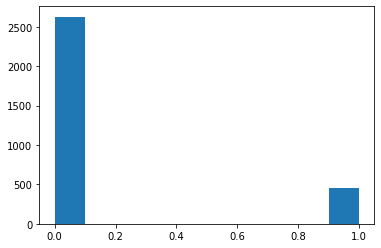

In [22]:
plt.hist(df_norm['isFradulent_Y'])
plt.show()

In [23]:
# 448 transacciones fraudulentas, 2627 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df_norm["isFradulent_Y"].value_counts()

0.0    2627
1.0     448
Name: isFradulent_Y, dtype: int64

In [24]:
df_norm.describe()

,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,Is declined_Y,isForeignTransaction_Y,isHighRiskCountry_Y,isFradulent_Y
count,3075.000000,3075.000000,3075.00000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,0.256021,0.091448,0.04787,0.055849,0.040103,0.043541,0.018537,0.229593,0.066667,0.145691
std,0.146247,0.093846,0.10962,0.207049,0.156281,0.172053,0.134903,0.420640,0.249484,0.352854
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133155,0.022304,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.249770,0.062027,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.381396,0.133542,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


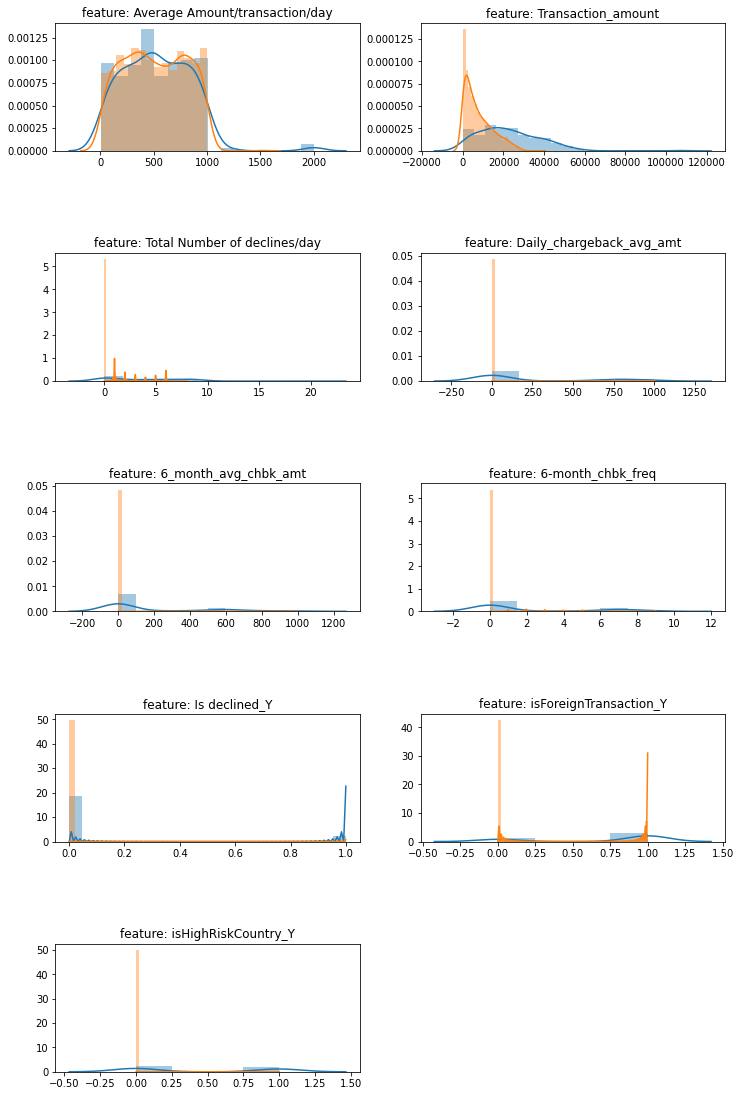

In [25]:
# Representamos gráficamente las características
features = df_norm.drop("isFradulent_Y", axis=1)

plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["isFradulent_Y"] == 1])
    sns.distplot(df[f][df["isFradulent_Y"] == 0])
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

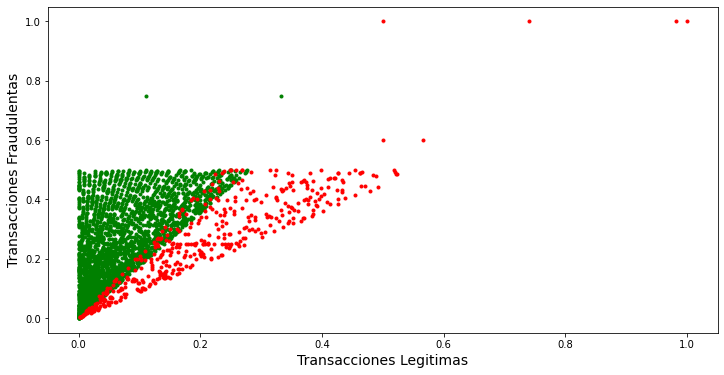

In [26]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df_norm["Transaction_amount"][df_norm['isFradulent_Y'] == 0], df_norm["Average Amount/transaction/day"][df_norm['isFradulent_Y'] == 0], c="g", marker=".")
plt.scatter(df_norm["Transaction_amount"][df_norm['isFradulent_Y'] == 1], df_norm["Average Amount/transaction/day"][df_norm['isFradulent_Y'] == 1], c="r", marker=".")
plt.xlabel("Transacciones Legitimas", fontsize=14)
plt.ylabel("Transacciones Fraudulentas", fontsize=14)
plt.show()

### KMEANS
<p align="justify">
Es uno de los algoritmos mas populares dentro del mundo del aprendizaje automático.  KMEANS utiliza como métrica para calcular la distancia entre los puntos la distancia euclídea, es un algoritmo sencillo que escala muy bien a grandes conjuntos de datos.
</p>

#### Limitaciones de algoritmos KMEANS.
<ul>
  <li> 
      <p align="justify">
Se debe intuir el número de clusters que genera el algoritmo, si son datos etiquetados, elegir el numero de clusters como un valor entre uno y tres el número de etiquetas existentes.
       </p>
  </li>
  <li> 
      <p align="justify">
Hay que aplicar normalización al conjunto de datos.
       </p>
  </li>
  <li> 
      <p align="justify">
No se debe utilizar KMEANS con datos categóricos a los que se aplican ONE-HOT ENCODING. Por el contrario, deben de tratar de codificarse estas características como múltiples.
       </p>
  </li>
  <li> 
      <p align="justify">
Pierde eficiencia con un conjunto de datos con muchas dimensiones. Una practica frecuente es reducir su dimensionalidad. 
       </p>
  </li>
  <li> 
      <p align="justify">
Funciona mejor si sus centroides iniciales se eligen aleatoriamente.
       </p>
  </li>
  <li> 
      <p align="justify">
Asume que los clustering son esféricos. No funcionan correctamente en distribuciones de datos no esféricas.
       </p>
  </li>
</ul>

## Kmeans con un conjunto de datos de dos dimensiones

<p align="justify">
Antes de comenzar con el entrenamiento de KMEANS para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.
</p>

In [27]:
X = df_norm[["Transaction_amount", "Average Amount/transaction/day"]].copy()
X

,Transaction_amount,Average Amount/transaction/day
0,0.027778,0.048091
1,0.039815,0.048091
2,0.044657,0.090927
3,0.046375,0.090927
4,0.240741,0.248493
...,...,...
3070,0.101852,0.248493
3071,0.000000,0.398794
3072,0.192593,0.398794
3073,0.111111,0.749498


In [28]:
# Generamos los clusters para nuestro conjunto de datos sin etiquetar
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

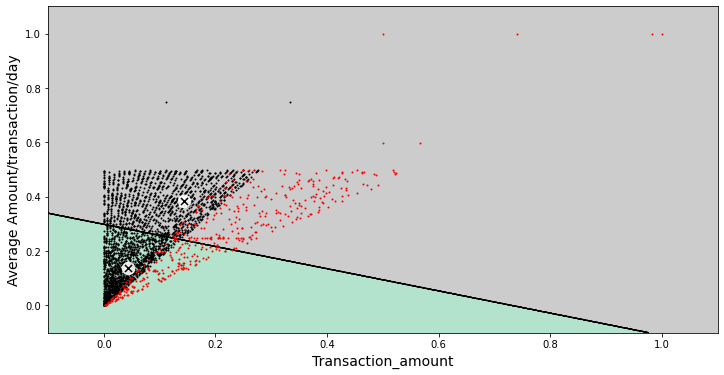

In [29]:
plt.figure(figsize=(12, 6))
plot_decision_boundaries(kmeans, X.values, df_norm["isFradulent_Y"].values)
plt.xlabel("Transaction_amount", fontsize=14)
plt.ylabel("Average Amount/transaction/day", fontsize=14)
plt.show()

In [30]:
from collections import Counter

In [31]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[df_norm['isFradulent_Y'] == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster 0 tiene 1593 ejemplos - 189 son maliciosos
Cluster 1 tiene 1482 ejemplos - 259 son maliciosos


## Kmeans con un conjunto de datos multidimensional

<p align="justify">
Al tratarse de un algoritmo basado en aprendizaje no supervisado, no se requieren las etiquetas para entrenar o predir. Hay que tener en cuenta que en este tipo de problemas se presupone que no se dispone de las etiquetas.
</p>

In [32]:
X = df_norm.drop("isFradulent_Y", axis=1)
y = df_norm["isFradulent_Y"].copy()

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

In [34]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster 0 tiene 2369 ejemplos - 127 son maliciosos
Cluster 1 tiene 706 ejemplos - 321 son maliciosos


## Reducción del número de características

En muchas ocasiones Kmeans funciona mejor con un número de características bajo.

## Aplicamos selección de características con Random Forest

In [35]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [36]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [37]:
# Reducimos el conjunto de datos a las 4 características más importantes
X_reduced = X[list(feature_importances_sorted.head(4).index)].copy()

In [38]:
X_reduced

,isHighRiskCountry_Y,Transaction_amount,Total Number of declines/day,6-month_chbk_freq
0,1.0,0.027778,0.25,0.000000
1,1.0,0.039815,0.25,0.000000
2,0.0,0.044657,0.25,0.000000
3,0.0,0.046375,0.40,0.000000
4,1.0,0.240741,0.00,0.666667
...,...,...,...,...
3070,0.0,0.101852,0.00,0.777778
3071,0.0,0.000000,0.00,0.777778
3072,0.0,0.192593,0.00,0.777778
3073,1.0,0.111111,0.00,0.777778


## Entrenamiento de KMEANS con el conjunto de datos reducido

In [39]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

In [40]:
# Evaluamos los clusters y el contenido que se han formado
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster 0 tiene 205 ejemplos - 203 son maliciosos
Cluster 1 tiene 2870 ejemplos - 245 son maliciosos


# Evaluación de los resultados

<p align="justify">
Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.
</p>

In [41]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(y, clusters))

Purity Score: 0.9196747967479675


In [42]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=3075))

Shiloutte:  0.8177993646362611


In [43]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Calinski harabasz:  4113.2026082175325


### DBSCAN.
<p align="justify">
Es un algoritmo de clustering basado en densidad no en distancia, infiere automáticamente el numero de clusters a partir del conjunto dado y funciona correctamente en distribuciones no esféricas. DBSCAN define un radio alrededor del conjunto de datos a partir del cual buscar ejemplos vecinos, a esto lo denomina EPSILON, siendo este el primer parámetro que recibe el algoritmo. Y un segundo parámetro llamado MINPOINTS que definen el numero de vecinos necesarios para formar un clúster. 
</p>

#### Limitaciones de algoritmos DBSCAN.
<ul>
  <li> 
      <p align="justify">
No funciona correctamente cuando los clusters del conjunto de datos tienen diferentes densidades.
       </p>
  </li>
  <li> 
      <p align="justify">
La selección de parámetros EPSILON y MINPOINTS es muy importante para el correcto funcionamiento del algoritmo.
       </p>
  </li>
  <li> 
      <p align="justify">
No se comporta adecuadamente para consunto de datos de muchas dimensiones.
       </p>
  </li>
</ul>

## DBSCAN con un conjunto de datos de dos dimensiones

In [44]:
X = df_norm[["Transaction_amount", "Average Amount/transaction/day"]].copy()
y = df_norm["isFradulent_Y"].copy()

In [45]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15, min_samples=13)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.15, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=13, n_jobs=None, p=None)

In [46]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker=".", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

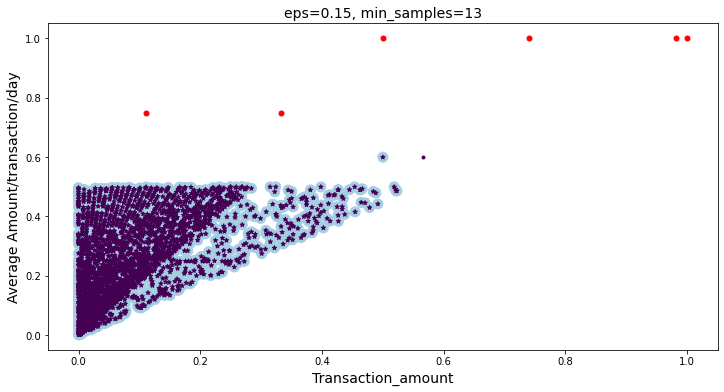

In [47]:
plt.figure(figsize=(12, 6))
plot_dbscan(dbscan, X.values, size=100)
plt.xlabel("Transaction_amount", fontsize=14)
plt.ylabel("Average Amount/transaction/day", fontsize=14)
plt.show()

In [48]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster -1 tiene 6 ejemplos - 4 son maliciosos
Cluster 0 tiene 3069 ejemplos - 444 son maliciosos


### DBSCAN con un conjunto de datos multidimensional

In [49]:
X = df_norm.drop("isFradulent_Y", axis=1)
y = df_norm["isFradulent_Y"].copy()

In [50]:
dbscan = DBSCAN(eps=0.15, min_samples=13)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.15, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=13, n_jobs=None, p=None)

In [51]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster -1 tiene 217 ejemplos - 138 son maliciosos
Cluster 0 tiene 175 ejemplos - 175 son maliciosos
Cluster 1 tiene 461 ejemplos - 88 son maliciosos
Cluster 2 tiene 2209 ejemplos - 35 son maliciosos
Cluster 3 tiene 13 ejemplos - 12 son maliciosos


## Reducción del número de características

## Aplicamos selección de características con Random Forest

In [52]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [53]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [54]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(4).index)].copy()

In [55]:
X_reduced

,isHighRiskCountry_Y,Transaction_amount,Total Number of declines/day,6-month_chbk_freq
0,1.0,0.027778,0.25,0.000000
1,1.0,0.039815,0.25,0.000000
2,0.0,0.044657,0.25,0.000000
3,0.0,0.046375,0.40,0.000000
4,1.0,0.240741,0.00,0.666667
...,...,...,...,...
3070,0.0,0.101852,0.00,0.777778
3071,0.0,0.000000,0.00,0.777778
3072,0.0,0.192593,0.00,0.777778
3073,1.0,0.111111,0.00,0.777778


## Entrenamiento de DBSCAN con el conjunto de datos reducido

In [56]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.70, min_samples=25)
dbscan.fit(X_reduced)

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=25, n_jobs=None, p=None)

In [57]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster 0 tiene 205 ejemplos - 203 son maliciosos
Cluster 1 tiene 2870 ejemplos - 245 son maliciosos


## Evaluación de los resultados

<p align="justify">
Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.
</p>

In [58]:
# Obtenemos los clusters del objeto dbscan
clusters = dbscan.labels_

In [59]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(y, clusters))

Purity Score: 0.9196747967479675


In [60]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=3075))

Shiloutte:  0.8177993646362611


In [61]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Calinski harabasz:  4113.2026082175325


### Clustering jerárquico
<p align="justify">
Es una aproximación de abajo hacia arriba (bottom-up) donde se dividen los clusters en sub clusters y así sucesivamente. Iniciando asignando cada muestra simple a un clúster y en cada iteración sucesiva va aglomerando (mezclando) el par de clusters más cercanos satisfaciendo algún criterio de similaridad, hasta que todos los elementos pertenecen a un solo clúster. Los clusters generados en los primeros pasos son anidados con los clusters generados en los siguientes pasos.
</p>

#### Limitaciones de algoritmos
<p align="justify">
En los métodos de aprendizaje supervisado es necesario crear clasificadores utilizando datos de prueba y test. Para detección de anomalías es mejor considerar que la información siempre esa segada. Por tanto, debe ser mejor una mayor cantidad de datos con éxito y unas pocas anomalías; esto generalmente es un problema para algoritmo de clasificación como clúster jerárquico.
</p>

## Clustering jerárquico con un conjunto de datos de dos dimensiones

In [62]:
from sklearn.cluster import AgglomerativeClustering

In [63]:
X = df_norm[["Transaction_amount", "Average Amount/transaction/day"]].copy()
y = df_norm["isFradulent_Y"].copy()

In [64]:
clus= AgglomerativeClustering(n_clusters=2, linkage="ward").fit(X)

In [65]:
counter = Counter(clus.labels_.tolist())
bad_counter = Counter(clus.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster 0 tiene 1460 ejemplos - 263 son maliciosos
Cluster 1 tiene 1615 ejemplos - 185 son maliciosos


Text(0, 0.5, 'isFradulent_Y')

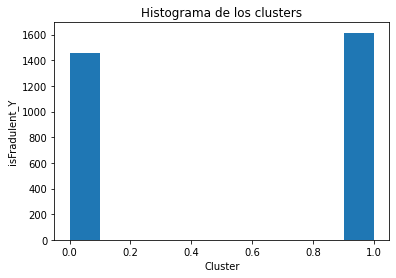

In [66]:
isFradulent_Y = pd.Series(clus.labels_)
plt.hist(isFradulent_Y)
plt.title("Histograma de los clusters")
plt.xlabel("Cluster")
plt.ylabel("isFradulent_Y")

##  Dendograma de un clustering jerárquico con un conjunto de datos de dos dimensiones

Un dendograma es una visualización grafica en forma de árbol que muestra el orden y las distancias de las uniones que ocurren en un clustering jerárquico

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [68]:
Z = linkage(X, "ward")

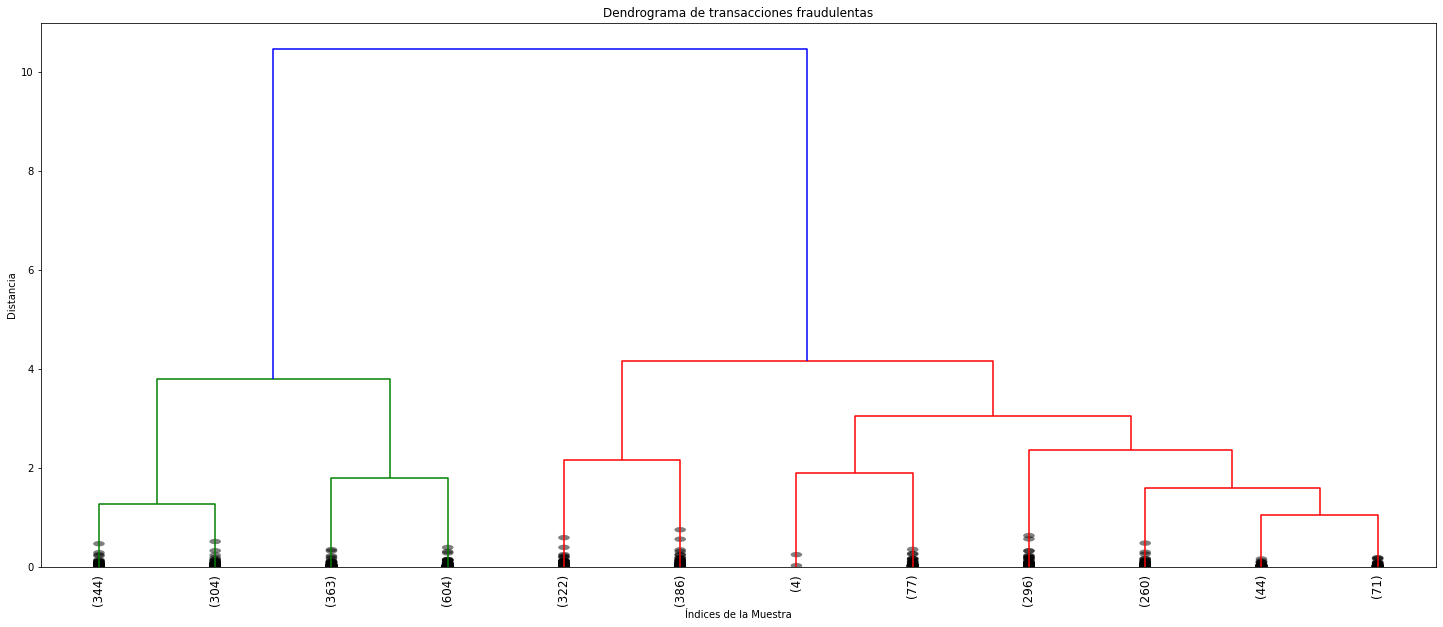

In [69]:
plt.figure(figsize=(25,10))
plt.title("Dendrograma de transacciones fraudulentas")
plt.xlabel("Índices de la Muestra")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90., leaf_font_size=12.0,
           truncate_mode="lastp", p=12, show_leaf_counts=True, show_contracted=True,)
plt.show()

## Clustering jerárquico con un conjunto de datos multidimensional

In [70]:
X = df_norm.drop("isFradulent_Y", axis=1)
y = df_norm["isFradulent_Y"].copy()

In [71]:
clus= AgglomerativeClustering(n_clusters=2, linkage="ward").fit(X)

In [72]:
counter = Counter(clus.labels_.tolist())
bad_counter = Counter(clus.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster 0 tiene 2438 ejemplos - 184 son maliciosos
Cluster 1 tiene 637 ejemplos - 264 son maliciosos


Text(0, 0.5, 'isFradulent_Y')

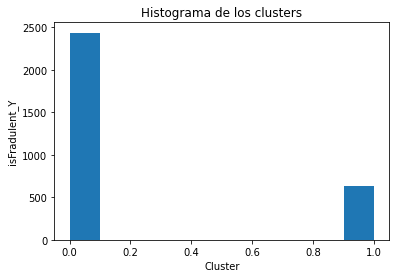

In [73]:
isFradulent_Y = pd.Series(clus.labels_)
plt.hist(isFradulent_Y)
plt.title("Histograma de los clusters")
plt.xlabel("Cluster")
plt.ylabel("isFradulent_Y")

## Dendograma de un clustering jerárquico con un conjunto de datos multidimensional

In [74]:
Z = linkage(X, "ward")

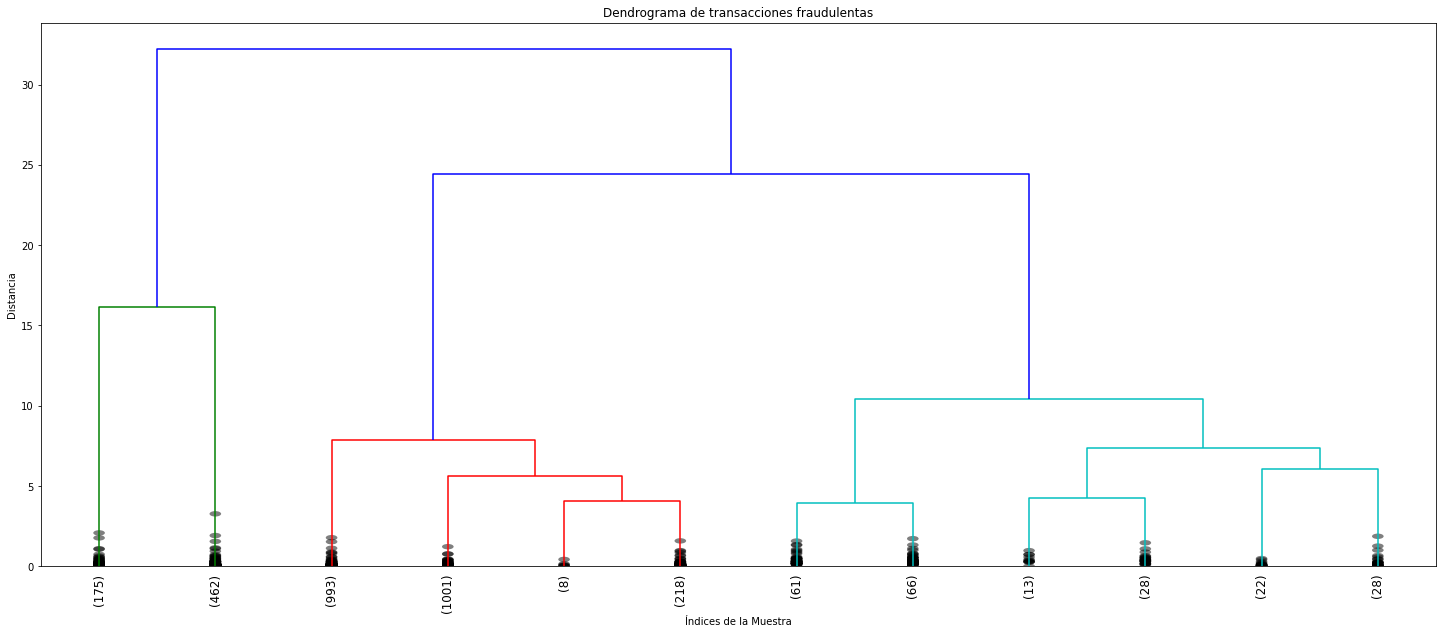

In [75]:
plt.figure(figsize=(25,10))
plt.title("Dendrograma de transacciones fraudulentas")
plt.xlabel("Índices de la Muestra")
plt.ylabel("Distancia")
#dendrogram(Z, leaf_rotation=90., leaf_font_size=4.)
dendrogram(Z, leaf_rotation=90., leaf_font_size=12.0,
           truncate_mode="lastp", p=12, show_leaf_counts=True, show_contracted=True,)
plt.show()

## Entrenamiento del Clustering jerárquico con el conjunto de datos reducido

In [76]:
clus= AgglomerativeClustering(n_clusters=2, linkage="ward").fit(X_reduced)

In [77]:
counter = Counter(clus.labels_.tolist())
bad_counter = Counter(clus.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} son maliciosos".format(
        key, counter[key], bad_counter[key]))

Cluster 0 tiene 2870 ejemplos - 245 son maliciosos
Cluster 1 tiene 205 ejemplos - 203 son maliciosos


## Dendograma de un clustering jerárquico con un conjunto de datos reducido

In [78]:
Z = linkage(X_reduced, "ward")

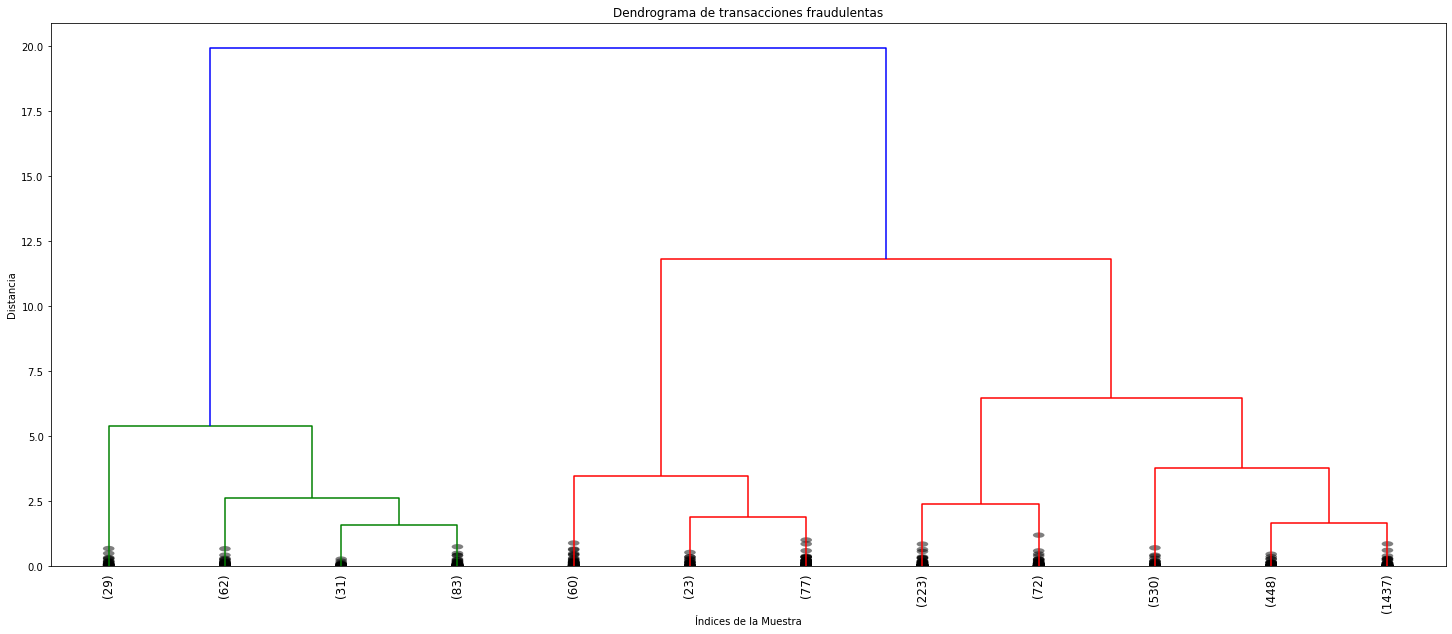

In [79]:
plt.figure(figsize=(25,10))
plt.title("Dendrograma de transacciones fraudulentas")
plt.xlabel("Índices de la Muestra")
plt.ylabel("Distancia")
dendrogram(Z, leaf_rotation=90., leaf_font_size=12.0,
           truncate_mode="lastp", p=12, show_leaf_counts=True, show_contracted=True,)
plt.show()

## Evaluación de los resultados

<p align="justify">
Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.
</p>

In [80]:
# Obtenemos los clusters del objeto dbscan
clusters = clus.labels_

In [81]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(y, clusters))


Purity Score: 0.9196747967479675


In [82]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", metrics.silhouette_score(X_reduced, clusters, sample_size=3075))

Shiloutte:  0.8177993646362612


In [83]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", metrics.calinski_harabasz_score(X_reduced, clusters))

Calinski harabasz:  4113.2026082175325


## Conclusiones
<p align="justify">


</p>

<p align="justify">
Después de a ver realizado diferentes experimentos, reduciendo el número de características atreves de bosques aleatorios seleccionando los cuatros variables más significativas dado que las técnicas de clustering funcionan mejor cuando se reducen su dimensionalidad obtuvimos los siguientes resultados.
</p>

KMEANS
<ul>
  <li>Cluster 0 tiene 205 ejemplos - 203 son maliciosos
  </li>
  <li>Cluster 1 tiene 2870 ejemplos - 245 son maliciosos
  </li>
</ul>

DBSCAN
<ul>
  <li>Cluster 0 tiene 205 ejemplos - 203 son maliciosos
  </li>
  <li>Cluster 1 tiene 2870 ejemplos - 245 son maliciosos
  </li>
</ul>

CLUSTERING JERÁRQUICO
<ul>
  <li>Cluster 0 tiene 2870 samples - 245 son maliciosos
  </li>
  <li>Cluster 1 tiene 205 samples - 203 son maliciosos
  </li>
</ul>

<p align="justify">
Se puede observar que en cada una de las técnicas tenesmos un clúster con 205 ejemplos teniendo 203 transacciones fraudulentas. Y un segundo clúster de 2870 ejemplos con 245 transacciones fraudulentas, es decir tenemos un clúster casi puro de transacciones fraudulentas casi un 40% del total de las transacciones ilegitimas. 
AL calcular su pureza (Técnica de evaluación de resultado en un algoritmo no supervisado cuando en el data set lo tenemos etiquetado) nos da un resultado de 0.92 un resultado muy cercano a 1 al parecer seria muy bueno, pero me queda la duda ya que el conjunto de datos esta muy desequilibrado, tenemos 448 transacciones fraudulentas y 2627 que no lo están, por su lado el índice de SHILOUTTE (nos da un numero entre -1 y 1 indicando si nuestros ejemplos están bien agrupados entres clusters, cuando el índice es muy cercano a 1 nos indica que es una buena agrupación y los clusters están muy bien separados) nos da un 0.81.
Para finalizar el índice de CALINSKI HARABASZ (técnica que permite evaluar que algoritmo funciona mejor) en los tres casos nos da el mismo resulta 4113.202
</p>

#Detección De Anomalías

## Isolation Forest
<p align="justify">
Es un algoritmo de detención de anomalías basados en el aprendizaje no supervisado, no perfila los datos normales (datos distribuidos en forma de campana de GAUSS), se basa en mediadas de distancias o densidad para identificar anomalías y funciona adecuadamente para conjunto de datos grandes. 
</p>
<p align="justify">
ISOLATION FOREST es un algoritmo robusto en relaciona los parámetros que recibe.
</p>
Parámetros relevantes:

<ul>
  <li>
  <p align="justify">
  N_ESTOMATORS: Son el número de estimadores bases en el conjunto. Es decir, el número de árboles que se construye.
  </p>
  </li>
   <li>
   <p align="justify">
 MAX_SAMPLES: El subconjunto de muestras que se extrae de X para entrenar cada estimador base. Es decir, el subconjunto de ejemplos dentro de datos que se utilizan para construir cada árbol.
 </p>
  </li>
  <li>
   <p align="justify">
 CONTAMINATION: Controla el THRESHOLD si un ejemplo es anómalo o normal. No influye en la construcción del modelo. Debe encontrarse dentro del rango [0, 0.5]
 </p>
  </li>
</ul>

## Isolation Forest con un conjunto de datos multidimensional

In [84]:
from sklearn.ensemble import IsolationForest

In [85]:
X = df_norm.drop("isFradulent_Y", axis=1)
y = df_norm["isFradulent_Y"].copy()

In [86]:
# Entrenamiento del modelo
ift_clf = IsolationForest(max_samples=300, contamination=0.1)
ift_clf.fit(X)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=300, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [87]:
# Identificación de anomalías
anomalies = ift_clf.predict(X)

In [88]:
print("Total de anomalías identificadas:", len(y[anomalies==-1]))

Total de anomalías identificadas: 308


In [89]:
# Verdaderos y falsos positivos de casos fraudulentos
y[anomalies==-1].value_counts()

1.0    239
0.0     69
Name: isFradulent_Y, dtype: int64

## Isolation Forest con un conjunto de datos reducidos
<p align="justify">
Separa las anomalías cerca de rama principal del nodo, y esta característica permite construir modelos parciales y efectivos incluso utilizando una poca cantidad de datos para entrenar los datos.
</p>
<p align="justify">
Este método tiene una complejidad lineal por tanto existe poco crecimiento de memoria lo cual es ideal para grandes volúmenes de conjuntos de tasos. Es por esto que, es muy utilizado generalmente en grandes bases de datos.
</p>
<p align="justify">
Las predicciones realizadas por este método pueden converger a un conjunto muy pequeño lo cual permite detectar anomalías de forma eficiente.
</p>
<p align="justify">
Para problemas con muchas variables, e incluso con variables irrelevantes para el modelo; puede crear funciones efectivas para la detección de anomalías incluso con estos atributos adicionales. Incluso trabaja bien si no existen anomalías presentes en el conjunto de datos.
</p>

In [90]:
# Entrenamiento del modelo
ift_clf = IsolationForest(max_samples=300, contamination=0.1)
ift_clf.fit(X_reduced)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=300, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [91]:
print("Total de anomalías identificadas:", len(y[anomalies==-1]))

Total de anomalías identificadas: 308


In [92]:
y.value_counts()

0.0    2627
1.0     448
Name: isFradulent_Y, dtype: int64

In [93]:
# Verdaderos y falsos positivos de casos fraudulentos
y[anomalies==-1].value_counts()

1.0    239
0.0     69
Name: isFradulent_Y, dtype: int64

## Búsqueda del mejor parámetro contaminación
<p align="justify">
Para utilizar de manera sencilla las técnicas estándar de búsqueda de hiperparámteros de sklearn, el estimador debe devolver un valor entre 0 y 1, sin embargo, la predicción de IsolationForest se encuentra comprendida entre -1 (ejemplo anómalo) y 1 (ejemplo normal). Construimos un estimador personalizado para que devuelva este resultado.
</p>

In [94]:
# Creamos nuestro propio estimador para que la salida del algoritmo este comprendida entre 0 y 1
from sklearn.base import BaseEstimator

class IsolationForestCustom(BaseEstimator):
    def __init__(self, max_samples=100, contamination=0.1):
        self.contamination = contamination
        self.max_samples = max_samples
        self._ift_clf = None
        
    def fit(self, X, y=None):
        self._ift_clf = IsolationForest(max_samples=self.max_samples, 
                                        contamination=self.contamination)
        self._ift_clf.fit(X) 
        return self
    
    def predict(self, X, y=None):
        preds = self._ift_clf.predict(X)
        preds[preds==1] = 0
        preds[preds==-1] = 1
        return preds
    
    def get_params(self, deep=True):
        return {"contamination": self.contamination,
               "max_samples": self.max_samples}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [95]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_samples': [100, 200, 300], 'contamination': [0.001, 0.01, 0.1]}

ift_clf = IsolationForestCustom()

# train across 5 folds, that's a total of 6*2=12 rounds of training 
grid_search = GridSearchCV(ift_clf, param_grid, cv=2,
                           scoring='f1', return_train_score=True)

grid_search.fit(X_reduced, y)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

GridSearchCV(cv=2, error_score=nan,
             estimator=IsolationForestCustom(contamination=0.1,
                                             max_samples=100),
             iid='deprecated', n_jobs=None,
             param_grid={'contamination': [0.001, 0.01, 0.1],
                         'max_samples': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)

In [96]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.13127413127413126 {'contamination': 0.001, 'max_samples': 100}
0.11287128712871287 {'contamination': 0.001, 'max_samples': 200}
0.11811023622047244 {'contamination': 0.001, 'max_samples': 300}
0.34334763948497854 {'contamination': 0.01, 'max_samples': 100}
0.31523378582202116 {'contamination': 0.01, 'max_samples': 200}
0.34433285509325684 {'contamination': 0.01, 'max_samples': 300}
0.404786680541103 {'contamination': 0.1, 'max_samples': 100}
0.4069400630914827 {'contamination': 0.1, 'max_samples': 200}
0.40966386554621853 {'contamination': 0.1, 'max_samples': 300}


In [97]:
grid_search.best_estimator_

IsolationForestCustom(contamination=0.1, max_samples=300)

## Conclusiones
<p align="justify">
Nuestro set de datos contiene 3.075 files, de las cuales 448 corresponden a transacciones fraudulentas y 267 corresponden a las que no lo son. En un algoritmo de detección de anomalías (ISOLATION FOREST) entre más anomalías correspondan con ejemplos fraudulentos será mejor para la detección de anomalías. Para este caso ISOLATION FOREST nos predice un total de 308 de transacciones anómalas. De las cuales 239 corresponden a transacciones fraudulentas y 69 que no lo son.
</p>

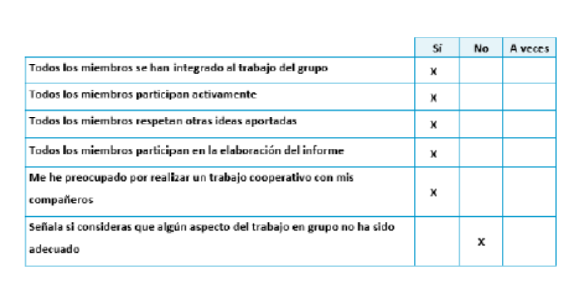

<p align="justify">
</p>